# Word2Vec (Negative Sampling)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
import nltk
from nltk.corpus import reuters
import pickle

In [6]:
# Check if CUDA is available and use GPU if yes
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
else:
    device = torch.device("cpu")   # Use CPU
    
print(device)

cuda


In [7]:
np.__version__, torch.__version__

('1.26.4', '2.5.1+cu124')

In [8]:
import matplotlib
matplotlib.__version__

'3.9.2'

## 1. Load data

In [9]:
corpus = reuters.sents(categories="grain")
corpus

[['CHINA', 'DAILY', 'SAYS', 'VERMIN', 'EAT', '7', '-', '12', 'PCT', 'GRAIN', 'STOCKS', 'A', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume', 'between', 'seven', 'and', '12', 'pct', 'of', 'China', "'", 's', 'grain', 'stocks', ',', 'the', 'China', 'Daily', 'said', '.'], ['It', 'also', 'said', 'that', 'each', 'year', '1', '.', '575', 'mln', 'tonnes', ',', 'or', '25', 'pct', ',', 'of', 'China', "'", 's', 'fruit', 'output', 'are', 'left', 'to', 'rot', ',', 'and', '2', '.', '1', 'mln', 'tonnes', ',', 'or', 'up', 'to', '30', 'pct', ',', 'of', 'its', 'vegetables', '.'], ...]

### 1. Tokenization

In [10]:
from nltk.corpus import stopwords
import string
import re

# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Regular expression to match double punctuations
double_punctuation_pattern = re.compile(r'[' + re.escape(string.punctuation) + ']{2,}')

# Function to clean the corpus
def clean_corpus(corpus):
    cleaned_corpus = []
    for sentence in corpus:
        cleaned_sentence = []
        for word in sentence:
            word = word.lower()
            # Check for stopwords, punctuation, and double punctuation
            if word not in stop_words and word not in punctuation and not double_punctuation_pattern.match(word):
                cleaned_sentence.append(word)
        cleaned_corpus.append(cleaned_sentence)
    return cleaned_corpus

# Clean the corpus
cleaned_corpus = clean_corpus(corpus)
cleaned_corpus

[['china',
  'daily',
  'says',
  'vermin',
  'eat',
  '7',
  '12',
  'pct',
  'grain',
  'stocks',
  'survey',
  '19',
  'provinces',
  'seven',
  'cities',
  'showed',
  'vermin',
  'consume',
  'seven',
  '12',
  'pct',
  'china',
  'grain',
  'stocks',
  'china',
  'daily',
  'said'],
 ['also',
  'said',
  'year',
  '1',
  '575',
  'mln',
  'tonnes',
  '25',
  'pct',
  'china',
  'fruit',
  'output',
  'left',
  'rot',
  '2',
  '1',
  'mln',
  'tonnes',
  '30',
  'pct',
  'vegetables'],
 ['paper',
  'blamed',
  'waste',
  'inadequate',
  'storage',
  'bad',
  'preservation',
  'methods'],
 ['said',
  'government',
  'launched',
  'national',
  'programme',
  'reduce',
  'waste',
  'calling',
  'improved',
  'technology',
  'storage',
  'preservation',
  'greater',
  'production',
  'additives'],
 ['paper', 'gave', 'details'],
 ['thai',
  'trade',
  'deficit',
  'widens',
  'first',
  'quarter',
  'thailand',
  'trade',
  'deficit',
  'widened',
  '4',
  '5',
  'billion',
  'baht',


### 2. Numeralization

In [11]:
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(cleaned_corpus))) #all the words we have in the system - <UNK>

In [12]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index['fuel']

553

In [13]:
len(vocabs)

6965

In [14]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 6965

In [15]:
index2word = {v:k for k, v in word2index.items()}

In [16]:
index2word[6965],word2index['<UNK>']

('<UNK>', 6965)

## 2. Prepare train data

In [23]:
#create pairs of center word, and outside word

def random_batch(batch_size, cleaned_corpus, window_size=2):

    skipgrams = []

    #loop each corpus
    for doc in cleaned_corpus:
        #look from the 2nd word until second last word
        for i in range(1, len(doc)-1):
            #center word
            center = word2index[doc[i]]
            #outside words = 2 words
            outside = (word2index[doc[i-1]], word2index[doc[i+1]])
            #for each of these two outside words, we gonna append to a list
            for each_out in outside:
                skipgrams.append([center, each_out])
                #center, outside1;   center, outside2
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)
            
x, y = random_batch(2, cleaned_corpus,2)

In [24]:
x.shape  #batch_size, 1

(2, 1)

In [25]:
x

array([[3416],
       [ 649]])

In [26]:
y.shape  #batch_size 1

(2, 1)

## 3. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [27]:
#count
from collections import Counter

word_count = Counter(flatten(corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

130144

$$P(w)=U(w)^{3/4}/Z$$

In [28]:
z = 0.001

In [29]:
unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)
    
Counter(unigram_table)

Counter({'said': 40,
         'tonnes': 28,
         'mln': 27,
         'wheat': 20,
         '1': 20,
         '000': 20,
         '87': 17,
         '2': 16,
         'year': 14,
         'pct': 14,
         '0': 14,
         'grain': 13,
         'corn': 13,
         '1986': 13,
         '5': 12,
         '4': 12,
         'would': 12,
         'last': 11,
         'dlrs': 11,
         '3': 11,
         'nil': 10,
         '1987': 9,
         '10': 8,
         '7': 8,
         '09': 8,
         'crop': 8,
         '6': 8,
         'prices': 8,
         '8': 8,
         'week': 8,
         '1985': 8,
         'export': 7,
         'farmers': 7,
         'per': 7,
         'market': 7,
         'production': 7,
         'trade': 7,
         'farm': 6,
         'government': 6,
         'imports': 6,
         '15': 6,
         '9': 6,
         '86': 6,
         'month': 6,
         '30': 6,
         'season': 6,
         'program': 6,
         'price': 6,
         'two': 6,
         '

## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [30]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs).to(device)

In [31]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [32]:
batch_size = 2
x, y = random_batch(batch_size, cleaned_corpus)
x_tensor = torch.LongTensor(x).to(device)
y_tensor = torch.LongTensor(y).to(device)

In [33]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [34]:
y_tensor[1]

tensor([3071], device='cuda:0')

In [35]:
neg_samples[1]

tensor([ 552, 6449, 3899, 5740, 6655], device='cuda:0')

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [36]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, window_size, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [38]:
#test your model
window_size = 2
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size).to(device)

In [39]:
loss = model(x_tensor, y_tensor, neg_samples)

In [40]:
loss

tensor(1.7008, device='cuda:0', grad_fn=<NegBackward0>)

## 5. Training

In [41]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [43]:
import time
start_time = time.time()

num_epochs = 1000

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, cleaned_corpus, window_size)
    input_tensor = torch.LongTensor(input_batch).to(device)
    label_tensor = torch.LongTensor(label_batch).to(device)
    
    #predict
    neg_samples = negative_sampling(label_tensor, unigram_table, k).to(device)
    loss = model(input_tensor, label_tensor, neg_samples)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")
        
    end_time = time.time()
    
total_time = start_time - end_time
min, sec = epoch_time(start_time, end_time)

print(f"Total loss: {loss} | time: {min} min {sec} sec")

Epoch    100 | Loss: 1.145044
Epoch    200 | Loss: 0.951511
Epoch    300 | Loss: 2.726258
Epoch    400 | Loss: 0.922460
Epoch    500 | Loss: 1.793846
Epoch    600 | Loss: 2.305470
Epoch    700 | Loss: 2.527813
Epoch    800 | Loss: 3.724137
Epoch    900 | Loss: 1.213204
Epoch   1000 | Loss: 2.880927
Total loss: 2.8809266090393066 | time: 3 min 17 sec


## 6. Plot the embeddings

In [48]:
fuel = torch.LongTensor([word2index['fuel']]).to(device)
fuel

tensor([553], device='cuda:0')

In [49]:
fuel_embed_c = model.embedding_center(fuel)
fuel_embed_o = model.embedding_outside(fuel)
fuel_embed   = (fuel_embed_c + fuel_embed_o) / 2
fuel_embed

tensor([[-0.2251,  0.2517]], device='cuda:0', grad_fn=<DivBackward0>)

In [50]:
fuel_embed_o

tensor([[0.4383, 0.1740]], device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [51]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]]).to(device)
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

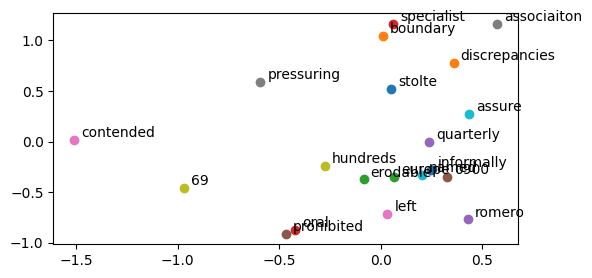

In [52]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs[:40:2]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

In [57]:
fuel = get_embed('fuel')
dollar = get_embed('dollar')

In [58]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"dollar vs. fuel: ",          cos_sim(dollar, fuel))

dollar vs. fuel:  0.9953792619354713


## 7. Save Model and Args

In [65]:
torch.save(model.state_dict(), 'model/word2vec_neg_sampling.pt')

In [66]:
Data = {
    'corpus': cleaned_corpus,
    'vocab': vocabs,
    'word2index': word2index,
    'voc_size': voc_size,
    'embedding_size': emb_size
}

In [67]:
pickle.dump(Data,open('model/neg_sampling_metadata.pkl', 'wb'))